In this part, we want to check our pre-trained model's performance with the randomly initialised model. Initially, the pre-trained model was trained to classify 62 classes but now it has to change its parameters to classify the 10 classes. The randomly initialised model has to learn all the parameters to classify the 10 classes. Ideally, both the models should have a similar performance as the pre-trained model has to adapt its parameters whereas the randomly initialised model has to learn from scratch.

In [42]:
#importing neccessary libraries

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator #for data augmentation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [43]:
# loading mnist dataset.
from tensorflow.keras.datasets import mnist
(X_train, y_train) , (X_test, y_test) = mnist.load_data()

## Pre-processing of data

To use the pre-trained model and use it efficiently I have to do the following things:

Firstly,
* To extract maximum features and gain maximum accuracy we used a 3 channel image in the model trained in part1. Since, I have to use the pre-trained model, I have to change the images of MNIST to  3 channel images. I am doing so by changing it's shape from 28x28x1 to 28x28x3 by simply replicating the same pixel values.

Secondly,
* The images given in part 1 were substantially bigger(1200x700) than the size of images in the MNIST dataset(28x28). In the model created for part 1, if we would have created a deep neural network keeping the same image size of (1200x700), then we would have faced difficulty while re-training the model on (28x28) images. This is because subsequent layers of convolution and max pooling would make the 28x28 images very small and therefore leading to a negative dimension error.

* If we would have resized the images in part 1 to 28x28 then the nueral network might not have been able to extract features efficiently as scaling down them would compress pixels nearer to each other. This would have made the model weaker as it would have been hard to distinguish between classes like 1 and l, 0 and a etc.

* Thus, to achieve optimal performance we would have to create a balance between the input sizes of the images and the depth of the neural network.

* Therefore, I chose to pad the MNIST images and increase their shape from 28x28 to 40x40.

In [44]:
# concatinating train and test data so that we can apply the neccessary transformations
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [45]:
# changing the shape by repeating the pixel values
X = X.reshape((70000, 28, 28, 1))
X = X.repeat(3, -1)  # repeating the last (-1) dimension three times

(28, 28, 3)


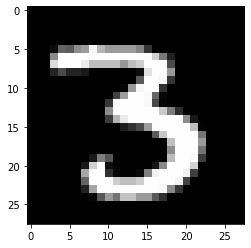

In [46]:
# sanity check
import matplotlib.pyplot as plt
plt.imshow(X[12])
print(X[12].shape)

In [47]:
# Function to pad pad images. Takes the image array of size 28*28 as the input and returns a numpy array of size 40x40. 
# The images are padded with black pixels.

# Taken from: https://www.geeksforgeeks.org/add-padding-to-the-image-with-python-pillow/
from PIL import Image
def pad_black(img):
    
    img = Image.fromarray(img) # converting the pixel array to image
    width, height = img.size

    # mentioning size of padding for all the four sides
    right = 6
    left = 6
    top = 6
    bottom = 6

    new_width = width + right + left
    new_height = height + top + bottom

    # pasting the padded sides on the image
    result = Image.new(img.mode, (new_width, new_height), (0, 0, 0))
    result.paste(img, (left, top))
    
    # converting the image back to a numpy array
    new_np = np.array(result)    
    return new_np

Since, we cannot directly change the values in a numpy array using indexing,I have changed it to list for applying neccessary operations and then converted it back to an numpy array.

In [48]:
X_list = list(X)
for i in range(len(X_list)):
    X_list[i]= pad_black(X_list[i])
    
X = np.array(X_list)
print(X.shape)

(70000, 40, 40, 3)


In [49]:
# splitting the data to the standard split of 60k images in training set and 10k images in testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 10000)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 40, 40, 3)
(10000, 40, 40, 3)
(60000,)
(10000,)


* Since normalizing the input helps in faster convergence I am normalizing all the pixel values to come between 0 and 1. 

In [50]:
# Normalizing the input for faster convergence
X_train = X_train.astype('float32')
X_train/=255

X_test = X_test.astype('float32')
X_test/=255

In [51]:
# creating classes
from  keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test= np_utils.to_categorical(y_test)

In [52]:
# sanity check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 40, 40, 3)
(60000, 10)
(10000, 40, 40, 3)
(10000, 10)


## -------------------- End of preprocessing --------------------

In [53]:
# loading pre-trained model
from tensorflow.keras.models import load_model
part1_model = load_model('../input/part1-model/part1_model')

In [54]:
part1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       1

The pre-trained model is not an end-to-end convolution network and it also has a different input shape. To tackle these issues I have made the following modifications:
* I had already taken care of the input by converting it into a 3 channel image. 
* I had used some dense layers in the last part of my pre-trained model. Since the shape of input images is diffirent, the same layers cannot be used for the mnist dataset as the input shape to the dense layer changes. The input to the dense layer in the pre-trained model was (None,200704), whereas the input to the dense layers for the current images of size (40x40) is (None, 1024). This difference in shapes leads to an error. Therefore, I have removed the dense layers of the pre-trained model and added a new dense layers with similar units.


In [55]:
# printing the layers to check for the index of dense layers
for layer in part1_model.layers:
    print(layer)

In [56]:
# initializing the model and the modified input layer to the model
model = Sequential()
model.add(Input(shape=(40,40,3)))

# adding the conv layers of the pre-trained model
for layer in part1_model.layers[0:-4]: # 3 pairs of convolutions and pooling layers i.e 6 layers
    model.add(layer)

# flattening the input from conv layers and adding the dense layers with similar units
# layer 7
model.add(Flatten())

#layer 8
model.add(Dense(512, activation='relu'))

#layer 9
model.add(Dense(256, activation='relu'))

# layer 10
model.add(Dense(128, activation = 'relu'))

# output layer
model.add(Dense(10, activation = 'softmax'))     

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                 

In [57]:
# callback for dynamically changing the learning rate of the model based on the validation loss.
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

#compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

# creating the checkpoint
checkpoint_filepath = '/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
                                            filepath=checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True
                                            )

# training the model
hist = model.fit(X_train, y_train,batch_size=32, epochs=50, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4363 - accuracy: 0.8511 - val_loss: 0.0718 - val_accuracy: 0.9790
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0775 - accuracy: 0.9765 - val_loss: 0.0449 - val_accuracy: 0.9863
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0623 - accuracy: 0.9825 - val_loss: 0.0498 - val_accuracy: 0.9860
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0555 - accuracy: 0.9844 - val_loss: 0.0543 - val_accuracy: 0.9839
Epoch 5/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0314 - accuracy: 0.9910 - val_loss: 0.0284 - val_accuracy: 0.9922
Epoch 6/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0209 - accuracy: 0.9937 - val_loss: 0.0260 - val_accuracy: 0.9924
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0250 - val_accuracy:

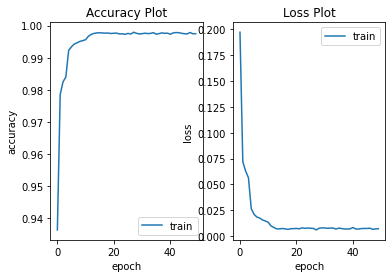

In [58]:
# plotting the loss and accuracy of the model.

# plotting the accuracy vs epochs
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title("Accuracy Plot")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])

# plotting the loss vs epochs
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title("Loss Plot")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

plt.show()

In [59]:
# Evaluating the performance of the pre-trained model on the current dataset
score = model.evaluate(X_test, y_test)
print("Testing loss : ", score[0])
print("Testing accuracy : ", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0261 - accuracy: 0.9931
Testing loss :  0.026115531101822853
Testing accuracy :  0.9930999875068665


In [60]:
# saving the model for using it in part 3
model.save('./part2_model')

In [61]:
# zipping all the output files in the kaggle working directory
!tar -zcvf outputname.tar.gz /kaggle/working

tar: Removing leading `/' from member names
/kaggle/working/
/kaggle/working/__notebook_source__.ipynb
/kaggle/working/part2_model/
/kaggle/working/part2_model/saved_model.pb
/kaggle/working/part2_model/assets/
/kaggle/working/part2_model/variables/
/kaggle/working/part2_model/variables/variables.index
/kaggle/working/part2_model/variables/variables.data-00000-of-00001
/kaggle/working/outputname.tar.gz
tar: /kaggle/working/outputname.tar.gz: file changed as we read it


## Randomly Initialized model

Training the images on a randomly initialized model. 
To make the random model comparable to the pre-trained model I have used the similar architecture. 
The only difference is that the convoltion layers in the previous models have been initialised with the pre-trained weights whereas the random model will be initiliazed with random parameters at the start. 

In [62]:
# initializing the model
random_model = Sequential()

# layer 1
random_model.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = 1, activation = 'relu', input_shape = (40, 40, 3)))

# layer 2
random_model.add(MaxPool2D(pool_size = (3, 3)))
random_model.add(Dropout(0.2))

# layer 3
random_model.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation = 'relu'))

# layer 4
random_model.add(MaxPool2D(pool_size = (2, 2)))
random_model.add(Dropout(0.2))

# layer 5
random_model.add(Conv2D(filters = 256, kernel_size = (2, 2), strides = 1, activation = 'relu'))

# layer 6
random_model.add(MaxPool2D(pool_size = (2, 2)))
random_model.add(Dropout(0.2))

# layer 7
random_model.add(Flatten())

# layer 8
random_model.add(Dense(512, activation='relu'))

# layer 9
random_model.add(Dense(256, activation='relu'))

# layer 10
random_model.add(Dense(128, activation='relu'))

# ouput layer
random_model.add(Dense(10, activation = 'softmax')) 

random_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 36, 36, 64)        4864      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)        

In [63]:
# learning rate changer
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

#compiling the model
random_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#checkpoint
random_checkpoint_filepath = '/checkpoint'
random_model_checkpoint_callback = ModelCheckpoint(
                                            filepath=random_checkpoint_filepath,
                                            save_weights_only=False,
                                            monitor='accuracy',
                                            mode='max',
                                            save_best_only=True
                                            )

# training the random model
random_hist = random_model.fit(X_train, y_train,batch_size=32, epochs=50, callbacks=[reduce_lr],validation_data = (X_test,y_test))

Epoch 1/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4299 - accuracy: 0.8520 - val_loss: 0.0706 - val_accuracy: 0.9766
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0747 - accuracy: 0.9773 - val_loss: 0.0515 - val_accuracy: 0.9846
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0611 - accuracy: 0.9821 - val_loss: 0.0448 - val_accuracy: 0.9881
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0491 - accuracy: 0.9864 - val_loss: 0.0491 - val_accuracy: 0.9865
Epoch 5/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0403 - accuracy: 0.9887 - val_loss: 0.0521 - val_accuracy: 0.9880
Epoch 6/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0256 - accuracy: 0.9929 - val_loss: 0.0305 - val_accuracy: 0.9916
Epoch 7/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0287 - val_accuracy:

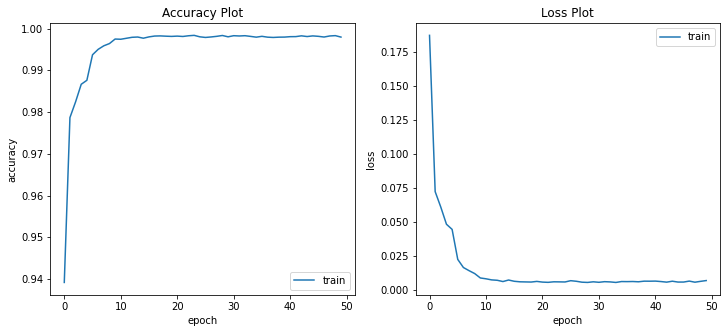

In [64]:
# plotting the loss and accuracy of the model.
plt.figure(figsize = (12, 5))

# plotting the accuracy vs epochs
plt.subplot(1,2,1)
plt.plot(random_hist.history['accuracy'])
plt.title("Accuracy Plot")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])

# plotting the loss vs epochs
plt.subplot(1,2,2)
plt.plot(random_hist.history['loss'])
plt.title("Loss Plot")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])

plt.show()

In [65]:
# Evaluating the performance of the randomly initialised model on the current dataset
random_model_score = random_model.evaluate(X_test, y_test)
print("Testing loss : ", random_model_score[0])
print("Testing accuracy : ", random_model_score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.0273 - accuracy: 0.9942
Testing loss :  0.02733689360320568
Testing accuracy :  0.9941999912261963


# Conclusion:

### Comparing training accuray and loss of both the models

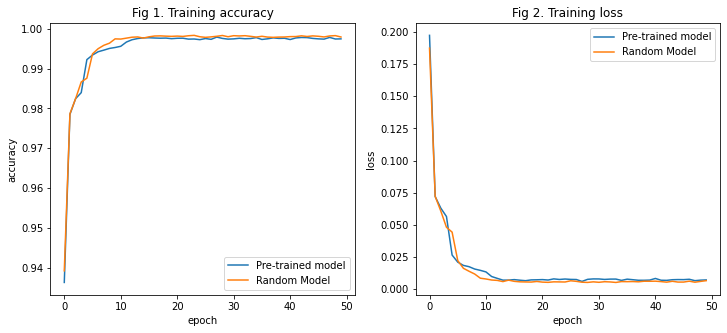

In [68]:
plt.figure(figsize = (12, 5))

# plotting the training accuracy of pre-trained and randomly initialised model
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(random_hist.history['accuracy'])

plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend(["Pre-trained model", "Random Model"])
plt.title("Fig 1. Training accuracy")

# plotting the training loss of pre-trained and randomly initialised model
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(random_hist.history['loss'])

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(["Pre-trained model", "Random Model"])
plt.title("Fig 2. Training loss")


plt.show()

### Comparing the testing accuracy and loss of both the models

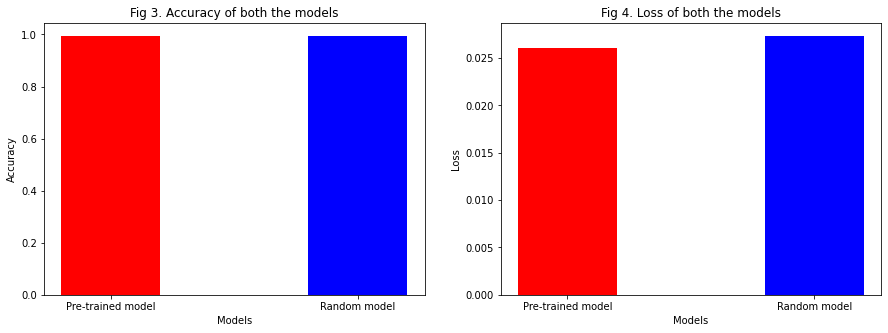

In [69]:
plt.figure(figsize = (15, 5))

# plotting the testing accuracy of pre-trained and randomly initialised model
plt.subplot(1,2,1)
X_acc = ["Pre-trained model", "Random model"]
y_acc = [score[1],random_model_score[1]]
plt.bar(X_acc, y_acc, color=['red','blue'], width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Fig 3. Accuracy of both the models")


# plotting the testing loss of pre-trained and randomly initialised model
plt.subplot(1,2,2)
X_loss = ["Pre-trained model", "Random model"]
y_loss = [score[0],random_model_score[0]]
plt.bar(X_loss, y_loss, color=['red','blue'], width = 0.4)
plt.xlabel("Models")
plt.ylabel("Loss")
plt.title("Fig 4. Loss of both the models")


plt.show()

### Training metrics of both the models

Model/metric | Accuracy | Loss |
-------------| --------- | ----------- |
Pre-trained model | 99.7% | 0.0074 |
Randomly initialised model | 99.6% | 0.069 |


### Testing metrics of both the models
Model/metric | Accuracy | Loss |
-------------| --------- | ----------- |
Pre-trained model | 99.3% | 0.026  |
Randomly initialised model | 99.45% | 0.027 |

* For the randomly initialised model, weights and biases for all the layers are initialised randomly. The model has to learn from the input images and adjust its parameters to classify the 10 classes of digits.
* On the other hand, the pre-trained model already has weights and biases initialised for the first 3 convolution layers. However, the parameters for the rest of the dense layers are learned during the training itself. 
* The parameters in the pre-trained model have been set to classify 62 classes. Also, the dense layers of the network have to be set during the training itself. These challenges do not affect the convergence largely since the 10 classes were a subset of the 62 classes and since we also have a larger dataset the model quickly adapts in the initial epochs itself.
* Conclusively, both the models have an equal number of parameters that need to be learned/changed. We can see from figure 1 that the convergence speed of both the models only differ by a few epochs(~2-3).
* Another factor that influences faster convergence in both the models is the normalization of input.
* If the input images were not normalized then we might have seen a larger difference in the convergence time of both models. 
* The dynamic learning rate also helps to reach a faster convergence in both the models. 
* At the end, both the models give the same accuracy and loss. This is predominantly because of the large dataset. Initially, there is some difference in the accuracy and loss but both the models quickly extract features and reach high accuracy and low error.
* The performance of both the models is similar also because of the similarity in the architecture of the models. The performance of the randomly initialised model would drastically vary if we increase or decrease the layers. This is because of the change in the number of trainable parameters.